In [42]:
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms,utils
import matplotlib.pyplot as plt
import torch.nn.functional as F



In [43]:
transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])   #needed to do grayscale cob=nversion before normalizing to tensor
trainset=datasets.CIFAR10('CIFAR10/',train=True,transform=transform,download=True)
train_loader=DataLoader(trainset,batch_size=64,shuffle=True) #use all three channels

testset=datasets.CIFAR10('CIFAR10/',train=False,transform=transform,download=True)
test_loader=DataLoader(testset,batch_size=64,shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


torch.Size([64, 3, 32, 32])
torch.Size([64])


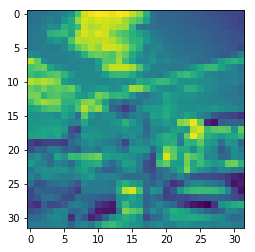

In [44]:
image,label=next(iter(train_loader))
print(image.size())
print(label.size())
plt.imshow(image[0][0,:])

In [45]:
label

tensor([ 0,  0,  9,  1,  4,  3,  2,  5,  6,  0,  6,  1,  7,  5,
         9,  8,  9,  0,  1,  3,  0,  8,  4,  7,  9,  4,  1,  5,
         4,  8,  3,  1,  5,  0,  1,  4,  1,  0,  2,  0,  4,  4,
         6,  5,  8,  0,  2,  1,  4,  2,  4,  2,  6,  6,  9,  1,
         0,  5,  0,  5,  5,  5,  7,  6])

In [46]:
class Network(torch.nn.Module):
    
    def __init__(self):
        super(Network,self).__init__()
        self.conv1=torch.nn.Conv2d(3,10,kernel_size=5)
        self.conv2=torch.nn.Conv2d(10,20,kernel_size=5)
        self.mxpool1=torch.nn.MaxPool2d(2)
        self.fc1=torch.nn.Linear(500,200)
        self.dropout1=torch.nn.Dropout(p=0.2)
        self.fc2=torch.nn.Linear(200,100)
        self.dropout2=torch.nn.Dropout(p=0.2)
        self.fc3=torch.nn.Linear(100,10)
        
        
        
    def forward(self,x):
        
        input_size=x.size(0)
        x=F.relu(self.mxpool1(self.conv1(x)))
        x=F.relu(self.mxpool1(self.conv2(x)))
        x=x.view(input_size,-1) #flatten the tensor
        x=F.relu(self.fc1(x))
        x=self.dropout1(x)
        x=F.relu(self.fc2(x))  
        x=self.dropout2(x)
        x=F.relu(self.fc3(x))
        y_pred=x                                                 
                    
        #x=x.view(-1,1024)  #flatten in forward instead of train

         #sof max at end, or sigmoid all the way did not work out
        #y_pred=F.softmax(out4,dim=1)   #if don't need probability as out put not necessary output4 is batch_size*10

        return y_pred

model=Network()    
    

In [47]:
epochs=10
criterion=torch.nn.CrossEntropyLoss()  #if increase the lr to 0.1, it kicks to local min and stays
optimizer=torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9)  #had to change from SGD to Adam but later noy much difference
lr_scheduler_=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#lr_scheduler_=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs)

In [48]:
#torch.set_printoptions(precision=2)
def train_function(train_loader):
    loss_running=0
    count=0
    count_batch=0
    sum_acc=0

    for epoch in range(epochs):

        for input,label in iter(train_loader):

            #input.resize_(input.size()[0], 784)   take to forward
            y_pred=model(input)   #this is 64 (bacth_size)*10

            if(count==0): print(y_pred.size(),label.size())
            loss=criterion(y_pred,label)    #criterion(y_pred,label), crossentropy criterion need long (output of forward) and normal tensor (target)
            loss_running=loss_running+loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            count=count+1
            #y_pred_round=torch.round(y_pred)
            count_batch=count_batch+(label.size()[0])
            _,y_pred_=torch.max(y_pred,dim=1)    #argmax is the second value returned by torch.max()  ,this collapse dimension to batch size with argmax of probabililty/value (second) item, first one is the value itself 

            acc=(label==y_pred_).sum().item()    #/label.size()[0]
            sum_acc=sum_acc+acc
            if(count%200==0): print('epoch',epoch+1,'/',epochs,'running_loss:',(loss_running/count_batch),'Accuracy',(sum_acc*100/count_batch))

        check_loss=(loss_running/count_batch)
        lr_scheduler_.step(check_loss)

train_function(train_loader)

torch.Size([64, 10]) torch.Size([64])
epoch 1 / 10 running_loss: 0.0354797759372741 Accuracy 14.828125
epoch 1 / 10 running_loss: 0.032295448537915945 Accuracy 22.91796875
epoch 1 / 10 running_loss: 0.030054268430297574 Accuracy 28.5390625
epoch 2 / 10 running_loss: 0.028547552087678365 Accuracy 32.524632467938694
epoch 2 / 10 running_loss: 0.02737326832608876 Accuracy 35.5266449837378
epoch 2 / 10 running_loss: 0.02645469666434398 Accuracy 37.81008963935793
epoch 2 / 10 running_loss: 0.025700199815957316 Accuracy 39.72998927997141
epoch 3 / 10 running_loss: 0.02506033534432878 Accuracy 41.41773537691586
epoch 3 / 10 running_loss: 0.02446680700767362 Accuracy 42.95072282457603
epoch 3 / 10 running_loss: 0.02395257202608752 Accuracy 44.23082937202902
epoch 3 / 10 running_loss: 0.023521140075022047 Accuracy 45.290823288605864
epoch 4 / 10 running_loss: 0.02313190417449885 Accuracy 46.28427692628506
epoch 4 / 10 running_loss: 0.02275242737062672 Accuracy 47.19107881820806
epoch 4 / 10 run

In [50]:
#torch.set_printoptions(precision=2)
def test_function(test_loader):
    loss_running=0
    count=0
    count_batch=0
    sum_acc=0

    for input,label in iter(test_loader):
        model.eval()

        #input.resize_(input.size()[0], 784)   take to forward
        y_pred=model(input)   #this is 64 (bacth_size)*10

        #if(count==0): print(y_pred.size(),label.size())
        loss=criterion(y_pred,label)    #criterion(y_pred,label), crossentropy criterion need long (output of forward) and normal tensor (target)
        loss_running=loss_running+loss.item()
        count=count+1

        count_batch=count_batch+(label.size()[0])
        _,y_pred_=torch.max(y_pred,dim=1)    #argmax is the second value returned by torch.max()  ,this collapse dimension to batch size with argmax of probabililty/value (second) item, first one is the value itself 

        acc=(label==y_pred_).sum().item()    #/label.size()[0]
        sum_acc=sum_acc+acc
        if(count%100==0): print('running_loss:',(loss_running/count_batch),'Accuracy',(sum_acc*100/count_batch))




test_function(test_loader)   # w/o convnet :result show over fitting on train 64%, but overall 50% on test is not too bad wihtout convnet
#w/ convnet just after 5 epoch training the test got to 63% (50% train)
#after 10 epoch test get to 66% pretty good without big networks

running_loss: 0.015260435463860631 Accuracy 66.375
